This dataset is presently only one of four on Kaggle with information on the rising risk of digital financial fraud, emphasizing the difficulty in obtaining such data. The main technical challenge it poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data. Another stumbling block to the utility of this data stems from the possible  discrepancies in its description <a href='https://www.kaggle.com/ntnu-testimon/paysim1/discussion/35004'>[1]</a>, <a href='https://www.kaggle.com/lightcc/money-doesn-t-add-up/'>[2]</a>, <a href='https://www.kaggle.com/ntnu-testimon/paysim1/discussion/32786'>[3]</a>. The goal of this analysis is to solve both these issues by a detailed data exploration and cleaning followed by choosing a suitable machine-learning algorithm to deal with the skew. I show that an optimal solution based on feature-engineering and extreme gradient-boosted decision trees yields an enhanced predictive power of 0.997, as measured by the area under the precision-recall curve. Crucially, these results were obtained without artificial balancing of the data making this approach  suitable to real-world applications.

Update: This notebook got the Kaggle kernel award for the first week of October 2017.

<a id='top'></a>
#### Outline: 
#### 1. <a href='#import'>Import</a>
#### 2. <a href='#EDA'>Exploratory Data Analysis</a>
21. <a href='#fraud-trans'>Which types of transactions are fraudulent?</a>
22. <a href='#isFlaggedFraud'>What determines whether the feature *isFlaggedFraud* gets set or not?</a>
23. <a href='#merchant'>Are expected merchant accounts accordingly labelled?</a>
24. <a href='#common-accounts'>Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?</a>

#### 3. <a href='#clean'>Data Cleaning</a>
31. <a href='#imputation'>Imputation of Latent Missing Values</a>

#### 4. <a href='#feature-eng'>Feature Engineering</a>
#### 5. <a href='#visualization'>Data Visualization</a>
51. <a href='#time'>Dispersion over time</a>
52. <a href='#amount'>Dispersion over amount</a>
53. <a href='#error'>Dispersion over error in balance in destination accounts</a>
54. <a href='#separation'>Separating out genuine from fraudulent transactions</a>
51. <a href='#correlation'>Fingerprints of genuine and fraudulent transactions</a>

#### 6. <a href='#ML'>Machine Learning to Detect Fraud in Skewed Data</a>
61. <a href='#importance'>What are the important features for the ML model?</a>
62. <a href='#decision-tree'>Visualization of ML model</a>
63. <a href='#learning-curve'>Bias-variance tradeoff</a>

#### 7. <a href='#conclusion'>Conclusion</a>

<a id='import'></a>
#### 1. Import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import data and correct spelling of original column headers for consistency

In [3]:
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


Test if there any missing values in DataFrame. It turns out there are no
obvious missing values but, as we will see below, this does not rule out proxies by a numerical
value like 0.

In [4]:
df.isnull().values.any()

False

<a href='#top'>back to top</a>

<a id='EDA'></a>
#### 2. Exploratory Data Analysis
In this section and until section 4, we wrangle with the data exclusively using Dataframe methods. This is the most succinct way to gain insights into the dataset. More elaborate visualizations follow in subsequent sections. 

<a id='fraud-trans'></a>
##### 2.1. Which types of transactions are fraudulent? 
We find that of the five types of transactions, fraud occurs only in two of them (see also kernels by <a href='https://www.kaggle.com/netzone/eda-and-fraud-detection'>Net</a>, <a href='https://www.kaggle.com/philschmidt/where-s-the-money-lebowski'>Philipp Schmidt</a> and <a href='https://www.kaggle.com/ibenoriaki/three-features-with-kneighbors-auc-score-is-0-998'>Ibe_Noriaki</a>):
'TRANSFER' where money is sent to a customer / fraudster
and 'CASH_OUT' where money is sent to a merchant who pays the customer / 
fraudster
in cash. Remarkably, the number of 
fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section <a href='#time'>5.1</a>). These
observations appear, at first, to bear out
the description provided on Kaggle for the modus operandi of fraudulent 
transactions in 
this dataset, namely, fraud is committed by first transferring out funds
to another account which subsequently cashes it out. We will return to this issue later in section <a href='#common-accounts'>2.4</a>

In [5]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


<a href='#top'>back to top</a>

<a id='isFlaggedFraud'></a>
##### 2.2. What determines whether the feature *isFlaggedFraud* gets set or not? 
It turns out that the origin of *isFlaggedFraud* is unclear, contrasting
with the description provided.
The 16 entries (out of 6 million) where the *isFlaggedFraud* feature 
is set 
do not seem to correlate with any
explanatory variable. The data is described as *isFlaggedFraud* being set when
an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. 
In
fact, as shown below, *isFlaggedFraud* can remain not set despite this condition being met.

In [6]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


Can *oldBalanceDest* and *newBalanceDest* determine *isFlaggedFraud* being
set?
The old is identical to the new balance in the origin and destination 
accounts, for every TRANSFER where *isFlaggedFraud* is set. This is presumably because 
the 
transaction is halted <a href='https://www.kaggle.com/lightcc/money-doesn-t-add-up/comments#187011'>[4]</a>.
Interestingly, *oldBalanceDest* = 0 in every such transaction. However, as shown below, since
*isFlaggedFraud* can remain not set in TRANSFERS where
*oldBalanceDest* and *newBalanceDest* can both be 0, these conditions do not
determine the state of *isFlaggedFraud*.



In [7]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


*isFlaggedFraud* being set cannot be thresholded on *oldBalanceOrig* since
the corresponding range of values overlaps with that for TRANSFERs where *isFlaggedFraud* is not set (see below). Note that we do not need
to consider *newBalanceOrig* since it is updated only after the transaction,
whereas *isFlaggedFraud* would be set before the transaction takes place.

In [8]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874.0, 19585040.0]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668.0]


Can *isFlaggedFraud* be set based on seeing a customer transacting more than
once? Note that duplicate customer names don't exist within transactions 
where *isFlaggedFraud* is set, but duplicate customer names exist within
transactions where *isFlaggedFraud* is not set. It turns out that originators
of transactions that have *isFlaggedFraud* set have transacted only once.
Very few destination accounts of transactions that have *isFlaggedFraud* set
have transacted more than once.

In [9]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


It can be easily seen that transactions with *isFlaggedFraud* 
set occur at
all values of *step*, similar to the complementary set of transactions. Thus
*isFlaggedFraud* does not correlate with *step* either and is therefore
seemingly unrelated to any explanatory variable or feature in the data

*Conclusion*: Although *isFraud* is always set when *isFlaggedFraud* is set, since
*isFlaggedFraud* is set just 16 times in a seemingly meaningless way, we 
can treat this feature as insignificant and discard it in the dataset 
without loosing information.

<a href='#top'>back to top</a>

<a id='merchant'></a>
##### 2.3. Are expected merchant accounts accordingly labelled?

It was stated <a href='http://www2.bth.se/com/edl.nsf/pages/phd-dissertation'>[5]</a> that CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have
merchants making CASH_IN transactions to customers.

In [10]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


Similarly, it was stated that CASH_OUT involves paying 
a merchant. However, for CASH_OUT transactions
there are no merchants among the destination accounts.

In [11]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In fact, there are no merchants among any originator accounts. Merchants are
only
present in destination accounts for all PAYMENTS.

In [12]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


*Conclusion*: Among the account labels *nameOrig* and *nameDest*, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

<a href='#top'>back to top</a>

<a id='common-accounts'></a>
##### 2.4. Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

From the data description, the modus operandi for committing fraud involves 
first making a TRANSFER to a (fraudulent) account which in turn 
conducts a CASH_OUT.
CASH_OUT involves transacting with a merchant who
pays out cash.
Thus, within this two-step process, the fraudulent account would be both, 
the destination in a TRANSFER
and the originator in a CASH_OUT. However, the data shows below that there are no 
such common accounts among 
fraudulent transactions. Thus, the data is not imprinted with
the expected modus-operandi.

In [13]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that
are not detected and are labeled as genuine? It turns out there are  3 such
accounts.

In [14]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


However, 2 out of 3 of these accounts first make a genuine CASH_OUT and 
only later 
(as evidenced by the
time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are
not indicated by the *nameOrig* and *nameDest* features.

In [15]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


*Conclusion*: Noting from section <a href='#merchant'>2.3</a>
above that
the *nameOrig* and *nameDest* features neither encode merchant accounts in the expected way, below, we
drop these features from the data since they are meaningless.

<a href='#top'>back to top</a>

<a id='clean'></a>
#### 3. Data cleaning

From the exploratory data analysis (EDA) of section <a href='#EDA#'>2</a>, we know that fraud only occurs in 
'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X
for analysis.

In [16]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

<a href='#top'>back to top</a>

<a id='imputation'></a>
##### 3.1. Imputation of Latent Missing Values

The data has several transactions with zero balances in the destination 
account both before and after a non-zero amount is transacted. The fraction
of such transactions, where zero likely denotes a missing value, is much 
larger
in fraudulent (50%) compared to genuine transactions (0.06%).

In [17]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Since the destination account balances being zero is a strong indicator of
fraud, we do not impute the account balance (before the transaction is made)
with a statistic or from a distribution with a subsequent adjustment for 
the amount transacted. Doing so would mask this
indicator of fraud and make fraudulent transactions appear genuine. Instead,
below we
replace the value of 0 with -1
which will be more useful to a suitable machine-learning (ML) algorithm detecting 
fraud.

In [18]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

The data also has several transactions with zero balances in the originating
account both before and after a non-zero amount is transacted. In this case,
the fraction of such transactions is much smaller in fraudulent (0.3%)
compared to genuine transactions (47%). Once again, from similar reasoning as
above, instead of imputing a 
numerical value we replace the value of 0 with a null value.

In [19]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

<a href='#top'>back to top</a>

<a id='feature-eng'></a>
#### 4. Feature-engineering

Motivated by the possibility of zero-balances serving to differentiate between
fraudulent and genuine transactions, we take the data-imputation of section <a href='#imputation'>3.1</a> a
step further and create 2 new features (columns) recording errors in the 
originating and
destination accounts for each transaction. These new features turn out to be 
important in obtaining the best performance from the ML algorithm that we will
finally use.

In [20]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

<a href='#top'>back to top</a>

<a id='visualization'></a>
#### 5. Data visualization

The best way of
confirming that the data contains enough information so that a ML algorithm 
can make strong predictions, is to try and directly visualize the 
differences between fraudulent and genuine transactions. Motivated by this
principle, I visualize these differences in several ways in the plots below.

In [21]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

<a id='time'></a>
##### 5. 1. Dispersion over time

The plot below shows how the fraudulent and genuine transactions yield different 
fingerprints when their dispersion is viewed over time. It is clear that
fradulent transactions are more homogenously distributed over time compared to 
genuine
transactions. Also apparent is 
that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to 
a balanced distribution between them in fraudulent transactions. Note that the
the width of each 
'fingerprint' is set by the 'jitter' parameter in the plotStrip function above
which attempts to separate out and plot transactions
occuring at the same time with different abscissae.

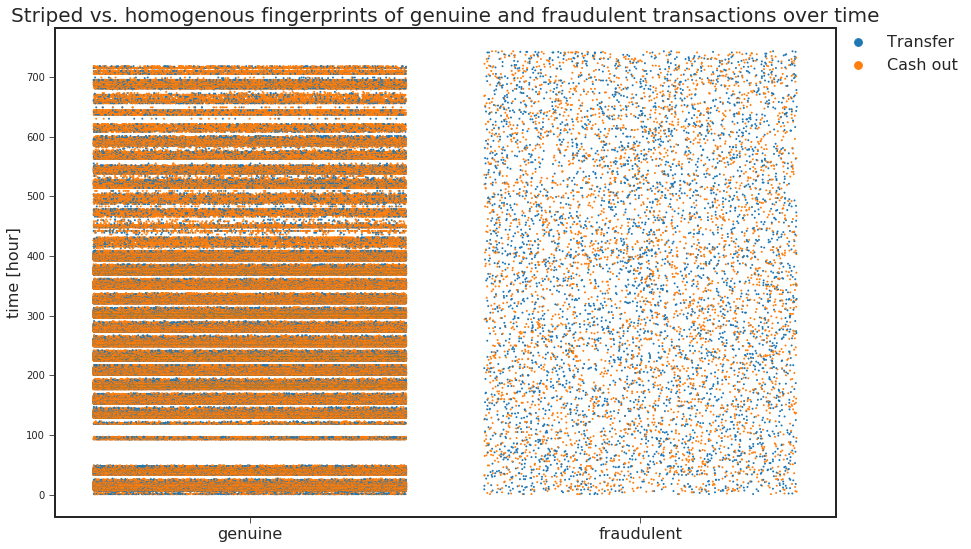

In [22]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

<a href='#top'>back to top</a>

<a id='amount'></a>
##### 5. 2. Dispersion over amount

The two plots below shows that although the presence of fraud in a transaction
can be discerned by the original *amount* feature, the new
*errorBalanceDest* feature is more effective at making a distinction.

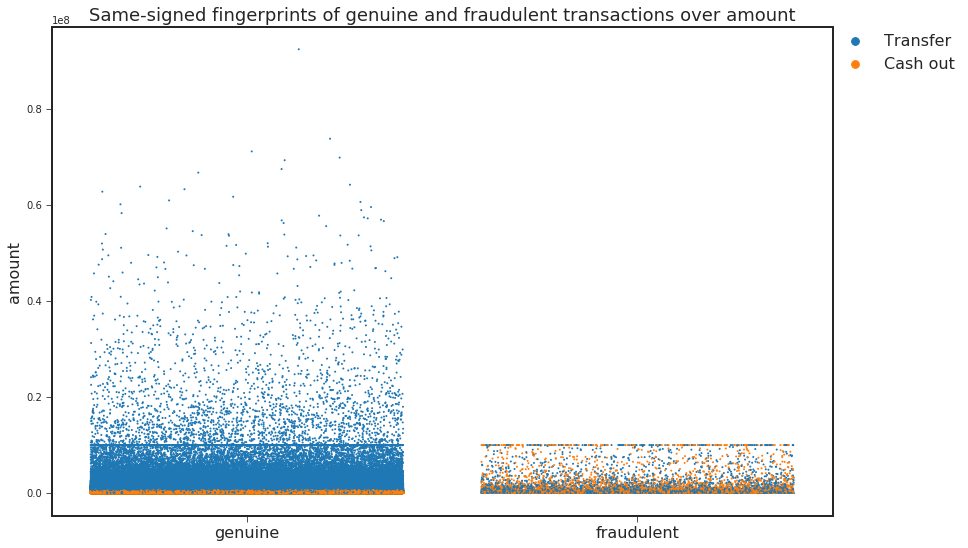

In [23]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

<a href='#top'>back to top</a>

<a id='error'></a>
##### 5. 3. Dispersion over error in balance in destination accounts

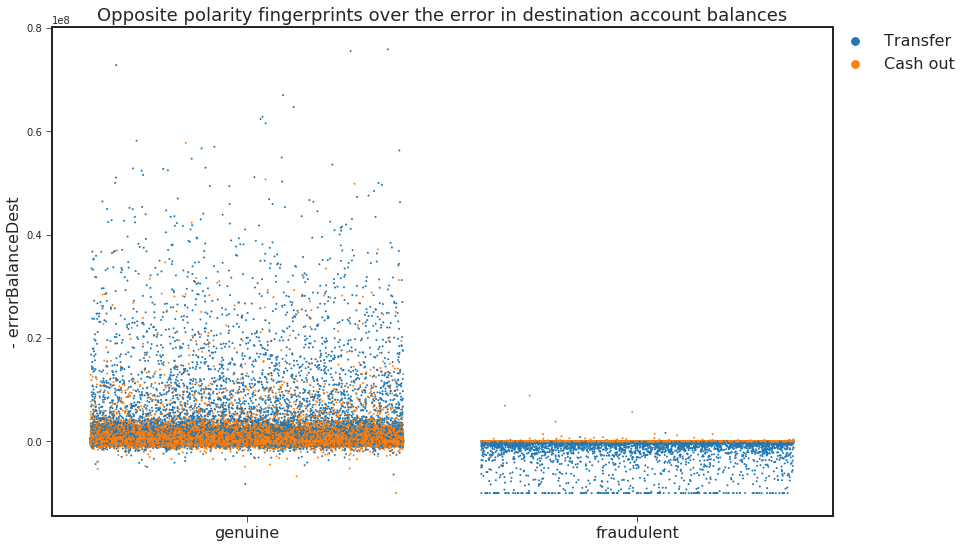

In [24]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

<a href='#top'>back to top</a>

<a id='separation'></a>
##### 5. 4. Separating out genuine from fraudulent transactions

The 3D plot below distinguishes best between fraud and non-fraud data
by using both of the engineered error-based features. Clearly, the
original *step* feature is ineffective in seperating out fraud. Note
the striped nature of the genuine data vs time which was aniticipated
from the figure in section <a href='#time'>5.1</a>.

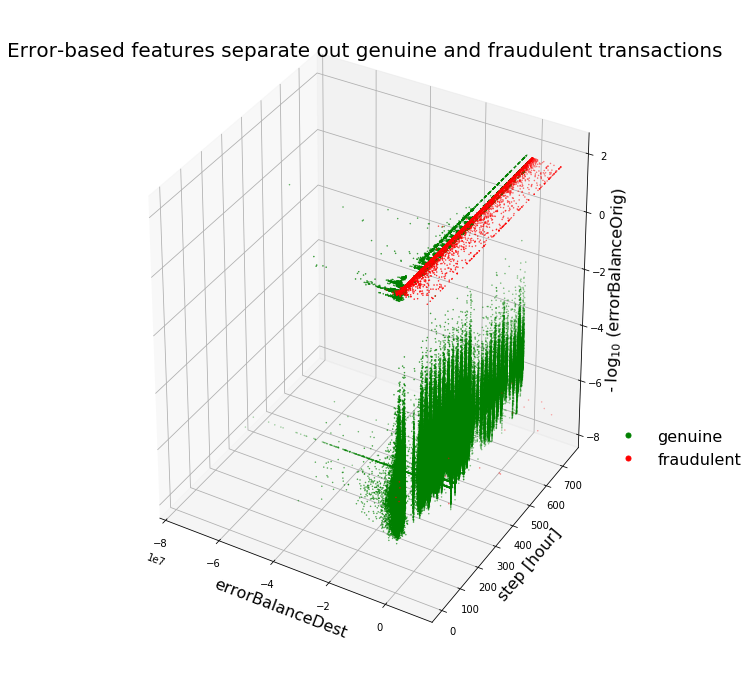

In [25]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

<a href='#top'>back to top</a>

<a id='correlation'></a>
##### 5. 5. Fingerprints of genuine and fraudulent transactions

Smoking gun and comprehensive evidence embedded in the dataset of the 
difference between fraudulent
and genuine transactions is obtained by examining their respective
correlations in the heatmaps below.

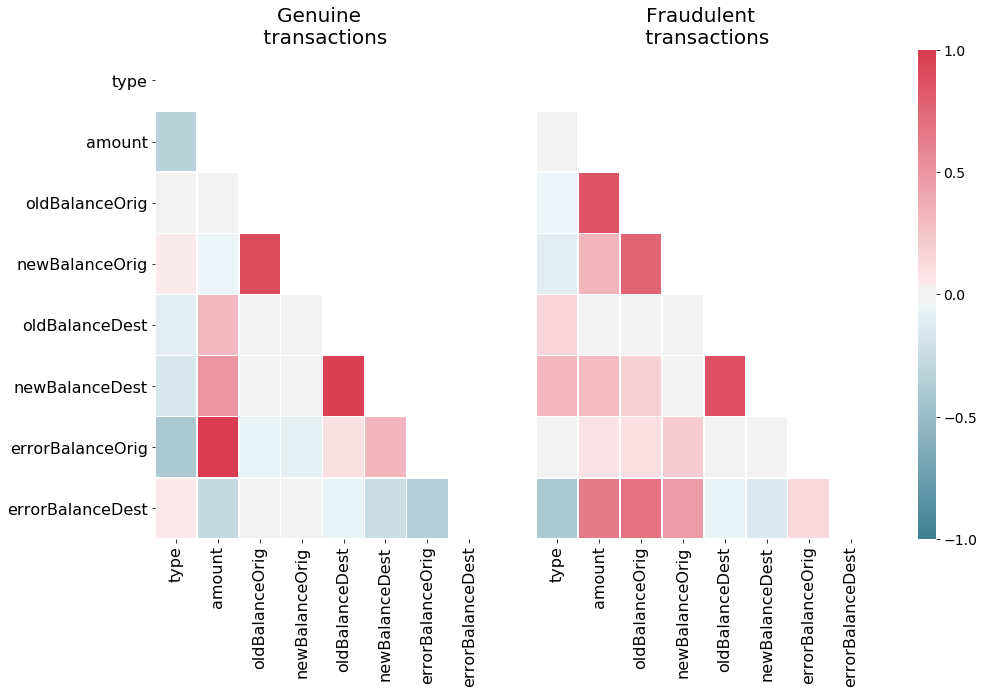

In [26]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

<a href='#top'>back to top</a>

<a id='ML'></a>
#### 6. Machine Learning to Detect Fraud in Skewed Data

Having obtained evidence from the plots above that the data now contains 
features that
make fraudulent transactions clearly 
detectable, the remaining obstacle for training a robust ML model is the highly 
imbalanced
nature of the data.

In [27]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


*Selection of metric*: 
Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (see <a href='http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf'>Davis and Goadrich, 2006</a>).

*Selection of ML algorithm*: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of  undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

Split the data into training and test sets in a 80:20 ratio

In [28]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [29]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9986361116985445


<a href='#top'>back to top</a>

<a id='importance'></a>
##### 6.1. What are the important features for the ML model?
The figure below shows that the new feature *errorBalanceOrig* that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

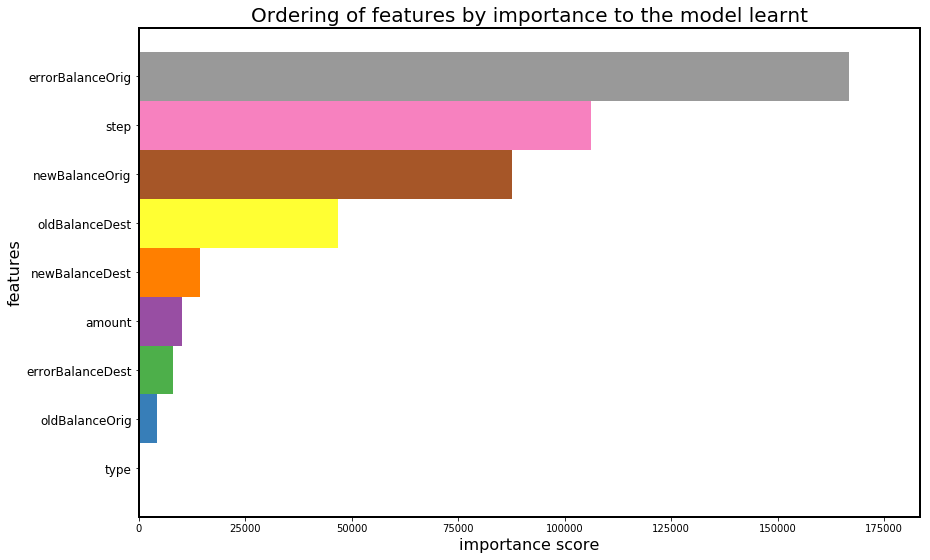

In [30]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

<a href='#top'>back to top</a>

<a id='decision-tree'></a>
##### 6.2. Visualization of ML model
The root node
in the decision tree visualized below is indeed
the feature *errorBalanceOrig*, 
as would be expected from its high significance to the
model.

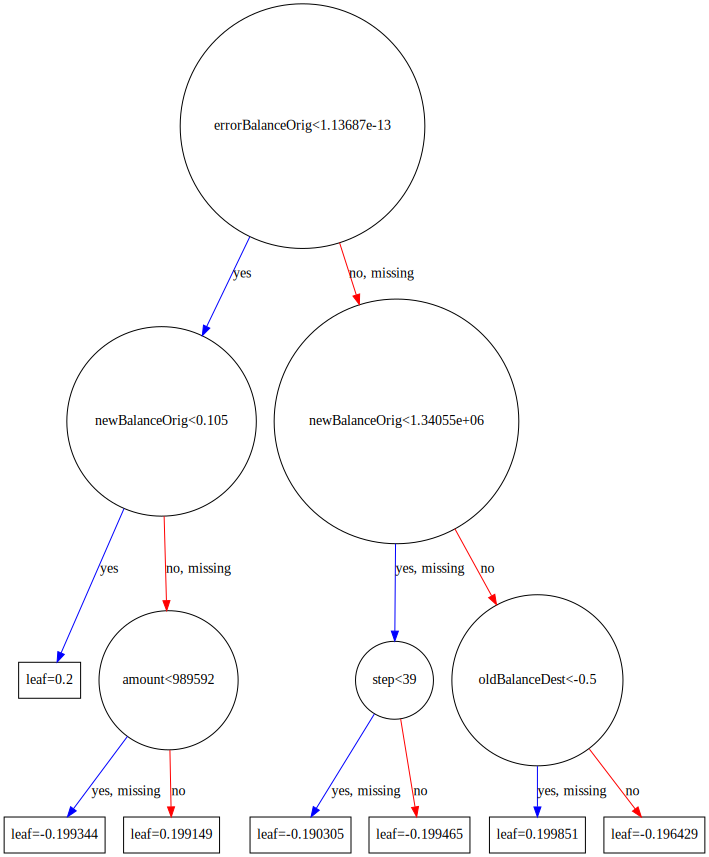

In [31]:
to_graphviz(clf)

<a href='#top'>back to top</a>

<a id='learning-curve'></a>
##### 6.3. Bias-variance tradeoff

The model we have learnt has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. The easiest way to improve the performance of the model still further is to increase the *max_depth* parameter of the XGBClassifier at the expense of the longer time spent learning the model. Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing *min_child_weight* and decreasing *reg_lambda*.

In [32]:
# Long computation in this cell (~6 minutes)

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

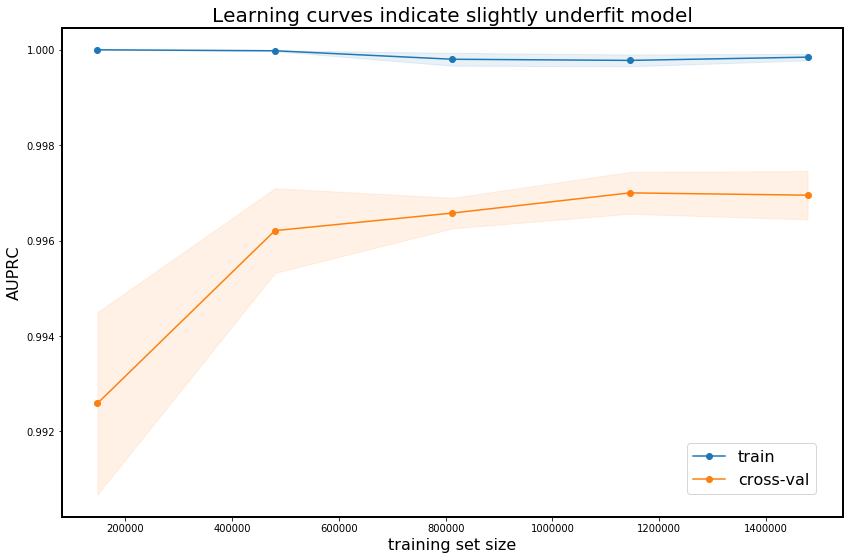

In [33]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

<a href='#top'>back to top</a>

<a id='conclusion'></a>
#### 7. Conclusion

We thoroughly interrogated the data at the outset to gain insight into which features could be discarded and those which could be valuably engineered. The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes. The method used in this kernel should therefore be broadly applicable to a range of such problems.

*Acknowledgements*: Thanks to Edgar Alonso Lopez-Rojas for posting this dataset.

*Hope you enjoyed reading this kernel as much as I had fun writing it. Please feel free to fork, upvote, and leave your comments to make my day* :-)

<a href='#top'>back to top</a>